# Configuración de la gpu

In [1]:
import tensorflow as tf
#crecimiento dinámico
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Memory growth set for GPUs:", gpus)

2026-02-12 02:19:48.995529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-12 02:19:49.028689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-12 02:19:49.975887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth set for GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Librerías

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import imagehash
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import random
import re
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Analisis del dataset

El dataset ya viene separado en train y test  
Al ser un dataset de imagenes, no es posible hacer un EDA tradicional, lo que si, podemos corroborar que no hay duplicados de imagenes en train y test, y en general, duplicados para evitar data leak

In [ ]:
train_path = "./Epic and CSCR hospital Dataset/Train/glioma"
test_path = "./Epic and CSCR hospital Dataset/Test/glioma"


# Función para obtener todas las imágenes
def get_image_paths(base_path):
    image_files = []
    for root, _, files in os.walk(base_path):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                image_files.append(os.path.join(root, f))
    return image_files


print("Cargando imágenes")

train_images = get_image_paths(train_path)
test_images = get_image_paths(test_path)

print("Train:", len(train_images))
print("Test:", len(test_images))

# Calcular hashes
def compute_hashes(image_list):
    hashes = {}
    for path in tqdm(image_list):
        try:
            img = Image.open(path).convert("RGB")
            h = imagehash.phash(img)
            hashes[path] = h
        except:
            continue
    return hashes


print("\n Calculando hashes Train...")
train_hashes = compute_hashes(train_images)

print("\n Calculando hashes Test...")
test_hashes = compute_hashes(test_images)           

# Comparar
print("\n Buscando duplicados...")

duplicates = []

threshold = 2  # menor = más estricto (0 es idéntico)

for path_k, hash_k in tqdm(test_hashes.items()):
    for path_m, hash_m in train_hashes.items():
        if hash_k - hash_m <= threshold:
            duplicates.append((path_k, path_m, hash_k - hash_m))

print("\n Total posibles duplicados:", len(duplicates))


Cargando imágenes
Train: 3018
Test: 755

 Calculando hashes Train...


100%|██████████| 3018/3018 [00:03<00:00, 829.07it/s]



 Calculando hashes Test...


100%|██████████| 755/755 [00:00<00:00, 756.73it/s]



 Buscando duplicados...


100%|██████████| 755/755 [00:02<00:00, 262.09it/s]


 Total posibles duplicados: 588


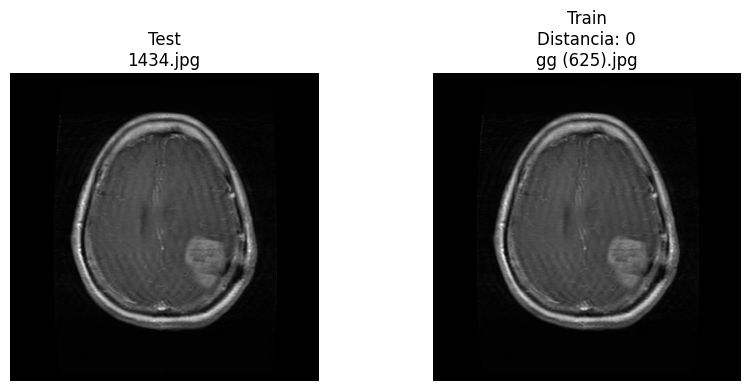

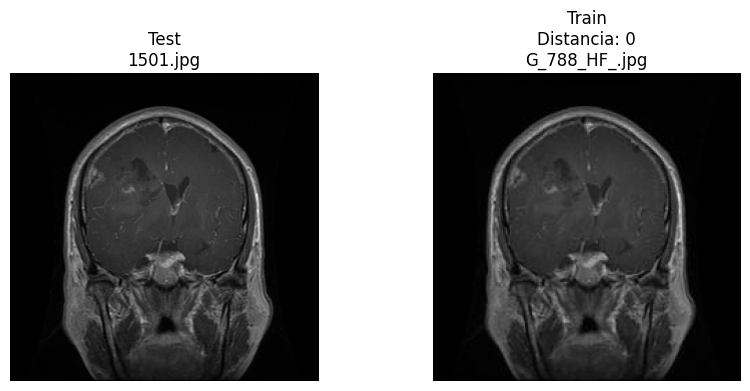

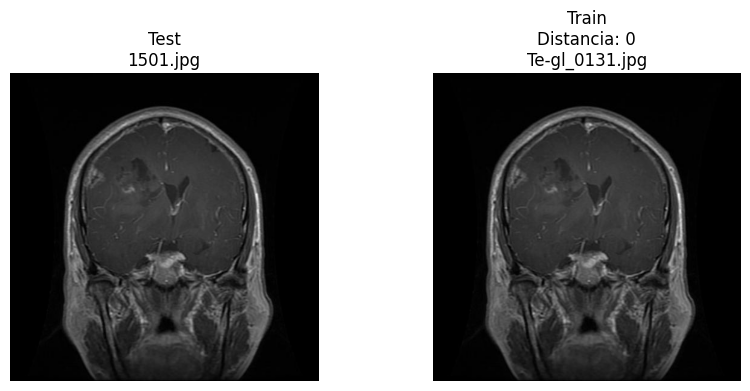

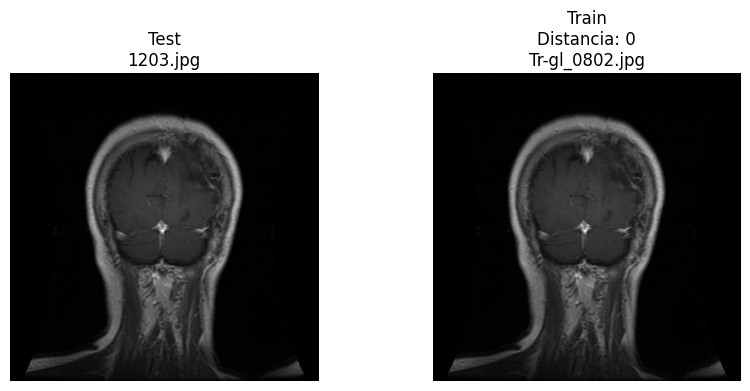

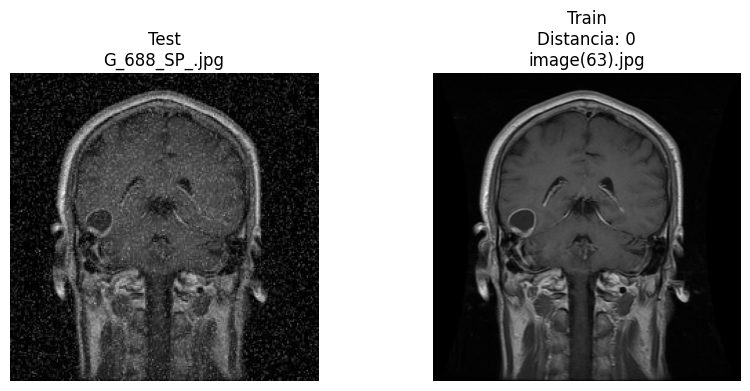

In [4]:
max_show = 5

for i, (k_path, m_path, dist) in enumerate(duplicates[:max_show]):
    
    img_k = Image.open(k_path).convert("RGB")
    img_m = Image.open(m_path).convert("RGB")

    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.imshow(img_k)
    plt.title(f"Test\n{os.path.basename(k_path)}")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(img_m)
    plt.title(f"Train\nDistancia: {dist}\n{os.path.basename(m_path)}")
    plt.axis("off")
    
    plt.show()

# Limpieza del dataset

In [5]:
#Función de limpieza sobre si mismos
def limpieza_self(train_car, threshold=5, clean_car=None):
    if clean_car:
        os.makedirs(clean_car, exist_ok=True)
    hash_dict = {}
    image_paths = []
    print(f"\n Escaneando imágenes en: {train_car}")
    for root, dirs, files in os.walk(train_car):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path).convert("RGB")
                    h = imagehash.phash(img)
                    image_paths.append((path, h))
                    hash_dict[path] = h
                except:
                    pass
    print(f"Total imágenes encontradas: {len(image_paths)}")

    unique_images = []
    seen_hashes = []

    for path, h in tqdm(image_paths):

        is_duplicate = False

        for existing_hash in seen_hashes:
            if h - existing_hash <= threshold:
                is_duplicate = True
                break

        if not is_duplicate:
            seen_hashes.append(h)
            unique_images.append(path)
    print(f"\n Imágenes únicas: {len(unique_images)}")
    print(f" Eliminadas: {len(image_paths) - len(unique_images)}")
    
    print("\n Copiando imágenes limpias...")

    for path in tqdm(unique_images):

        relative_path = os.path.relpath(path, train_car)
        new_path = os.path.join(clean_car, relative_path)

        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        shutil.copy2(path, new_path)

    print("\n Carpeta de imágenes limpias creada correctamente.")

In [6]:
train_c = "./Epic and CSCR hospital Dataset/Train"
test_c = "./Epic and CSCR hospital Dataset/Test"
limpieza_self(train_c, threshold=1, clean_car="./Epic and CSCR hospital Dataset/Train_clean")
limpieza_self(test_c, threshold=1, clean_car="./Epic and CSCR hospital Dataset/Test_clean")


 Escaneando imágenes en: ./Epic and CSCR hospital Dataset/Train
Total imágenes encontradas: 9650


100%|██████████| 9650/9650 [00:42<00:00, 225.38it/s] 



 Imágenes únicas: 7324
 Eliminadas: 2326

 Copiando imágenes limpias...


100%|██████████| 7324/7324 [00:00<00:00, 15327.08it/s]



 Carpeta de imágenes limpias creada correctamente.

 Escaneando imágenes en: ./Epic and CSCR hospital Dataset/Test
Total imágenes encontradas: 2414


100%|██████████| 2414/2414 [00:02<00:00, 805.53it/s] 



 Imágenes únicas: 2093
 Eliminadas: 321

 Copiando imágenes limpias...


100%|██████████| 2093/2093 [00:07<00:00, 279.85it/s]


 Carpeta de imágenes limpias creada correctamente.


In [7]:
train_root = "./Epic and CSCR hospital Dataset/Train_clean"
test_root = "./Epic and CSCR hospital Dataset/Test_clean"
clean_root = "./Epic and CSCR hospital Dataset/Test_clean_plus"

threshold = 1  # distancia 0 y 1

classes = os.listdir(train_root)

total_removed = 0
total_kept = 0

for class_name in classes:
    
    print(f"\n Procesando clase: {class_name}")
    
    train_class_path = os.path.join(train_root, class_name)
    test_class_path = os.path.join(test_root, class_name)
    
    # Obtener imágenes
    train_images = [
        os.path.join(train_class_path, f)
        for f in os.listdir(train_class_path)
        if f.lower().endswith(('.png','.jpg','.jpeg','.webp'))
    ]
    
    test_images = [
        os.path.join(test_class_path, f)
        for f in os.listdir(test_class_path)
        if f.lower().endswith(('.png','.jpg','.jpeg','.webp'))
    ]
    
    print(f"Train: {len(train_images)} | Test: {len(test_images)}")
    
    # Calcular hashes train
    train_hashes = []
    for img_path in tqdm(train_images, desc="Hash train"):
        try:
            img = Image.open(img_path).convert("RGB")
            train_hashes.append(imagehash.phash(img))
        except:
            continue
    
    kept = 0
    removed = 0
    
    # Crear carpeta destino
    clean_class_path = os.path.join(clean_root, class_name)
    os.makedirs(clean_class_path, exist_ok=True)
    
    # Filtrar test
    for test_img in tqdm(test_images, desc="Filtrando test"):
        try:
            img = Image.open(test_img).convert("RGB")
            test_hash = imagehash.phash(img)
        except:
            continue
        
        duplicate = False
        
        for train_hash in train_hashes:
            if test_hash - train_hash <= threshold:
                duplicate = True
                break
        
        if not duplicate:
            shutil.copy2(
                test_img,
                os.path.join(clean_class_path, os.path.basename(test_img))
            )
            kept += 1
        else:
            removed += 1
    
    print(f" Mantenidas: {kept}")
    print(f" Eliminadas: {removed}")
    
    total_kept += kept
    total_removed += removed


print("\n==============================")
print("TOTAL MANTENIDAS:", total_kept)
print("TOTAL ELIMINADAS:", total_removed)
print("==============================")
print("\n Cantidad de imágenes por clase en Train_clean y Test_clean_plus:")
classes = os.listdir(clean_root)
for class_name in classes:
    train_count = len(os.listdir(os.path.join(train_root, class_name)))
    test_count = len(os.listdir(os.path.join(clean_root, class_name)))
    print(f"{class_name}: Train_clean={train_count} | Test_clean_plus={test_count}")



 Procesando clase: glioma
Train: 2585 | Test: 690


Filtrando test: 100%|██████████| 690/690 [00:02<00:00, 237.09it/s]


 Mantenidas: 308
 Eliminadas: 382

 Procesando clase: notumor
Train: 1116 | Test: 388


Filtrando test: 100%|██████████| 388/388 [00:00<00:00, 458.85it/s]


 Mantenidas: 116
 Eliminadas: 272

 Procesando clase: pituitary
Train: 2052 | Test: 563


Filtrando test: 100%|██████████| 563/563 [00:02<00:00, 261.53it/s]


 Mantenidas: 127
 Eliminadas: 436

 Procesando clase: meningioma
Train: 1571 | Test: 452


Filtrando test: 100%|██████████| 452/452 [00:01<00:00, 352.36it/s]

 Mantenidas: 273
 Eliminadas: 179

TOTAL MANTENIDAS: 824
TOTAL ELIMINADAS: 1269

 Cantidad de imágenes por clase en Train_clean y Test_clean_plus:
glioma: Train_clean=2585 | Test_clean_plus=308
notumor: Train_clean=1116 | Test_clean_plus=116
pituitary: Train_clean=2052 | Test_clean_plus=127
meningioma: Train_clean=1571 | Test_clean_plus=273


# Parición de test para tener un dataset final que probar

In [11]:
random.seed(42)

SRC_DIR = "./Epic and CSCR hospital Dataset/Test_clean_plus"
VAL_DIR = "./Epic and CSCR hospital Dataset/Validacion"
TEST_FINAL_DIR = "./Epic and CSCR hospital Dataset/Test_final"

SPLIT = 0.8 # 80% val, 20% test final

for class_name in os.listdir(SRC_DIR):
    class_path = os.path.join(SRC_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(len(images) * SPLIT)
    val_imgs = images[:split_idx]
    test_imgs = images[split_idx:]

    os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(TEST_FINAL_DIR, class_name), exist_ok=True)

    for img in val_imgs:
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(VAL_DIR, class_name, img)
        )

    for img in test_imgs:
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(TEST_FINAL_DIR, class_name, img)
        )

print("División completada")

División completada


# Lectura y preprocesamiento de las imagenes

In [13]:
train_dir = "./Epic and CSCR hospital Dataset/Train/"
val_dir  = "./Epic and CSCR hospital Dataset/Validacion/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def imagenet_preprocess(x):
    x = x / 255.0
    mean = tf.constant([0.485, 0.456, 0.406])
    std  = tf.constant([0.229, 0.224, 0.225])
    return (x - mean) / std


train_gen = ImageDataGenerator(
    preprocessing_function=imagenet_preprocess,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=imagenet_preprocess
)


train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 9650 images belonging to 4 classes.
Found 657 images belonging to 4 classes.


In [14]:
print(train_data.class_indices)
print(val_data.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Estructura de la red

In [15]:
def build_cnn():
    model = models.Sequential([
        
        # Bloque 1
        layers.Conv2D(32, (3,3), padding="same", input_shape=(224,224,3)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        # Bloque 2
        layers.Conv2D(64, (3,3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.30),

        # Bloque 3
        layers.Conv2D(128, (3,3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.35),

        # Bloque 4
        layers.Conv2D(256, (3,3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.40),

        layers.Flatten(),

        # Fully Connected
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.5),

        layers.Dense(train_data.num_classes, activation='softmax')
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

cnn = build_cnn()
cnn.summary()

/home/port-mamalona/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/port-mamalona/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1770884989.377931   19795 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 13,237,700 (50.50 MB)

 Trainable params: 13,236,228 (50.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [16]:
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath="models_2/model_{val_accuracy:.3f}.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [17]:
history_cnn = cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/200


2026-02-12 02:29:52.667065: I external/local_xla/xla/service/service.cc:163] XLA service 0x721758016bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-12 02:29:52.667080: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2026-02-12 02:29:52.716182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-12 02:29:53.034318: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-12 02:29:53.268093: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-12 02:29:53.

  2/302 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.2656 - loss: 1.8252   

I0000 00:00:1770885002.617466   20455 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/302 ━━━━━━━━━━━━━━━━━━━━ 33s 265ms/step - accuracy: 0.4645 - loss: 1.4913

2026-02-12 02:30:49.488036: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3512', 4 bytes spill stores, 4 bytes spill loads



302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4862 - loss: 1.3846
Epoch 1: val_accuracy improved from None to 0.47641, saving model to models_2/model_0.476.keras

Epoch 1: finished saving model to models_2/model_0.476.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 102s 298ms/step - accuracy: 0.5342 - loss: 1.1871 - val_accuracy: 0.4764 - val_loss: 1.3296
Epoch 2/200
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6013 - loss: 0.9813
Epoch 2: val_accuracy did not improve from 0.47641
302/302 ━━━━━━━━━━━━━━━━━━━━ 86s 284ms/step - accuracy: 0.6219 - loss: 0.9457 - val_accuracy: 0.4627 - val_loss: 1.2396
Epoch 3/200
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6774 - loss: 0.8434
Epoch 3: val_accuracy did not improve from 0.47641
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.6925 - loss: 0.8051 - val_accuracy: 0.4414 - val_loss: 1.4090
Epoch 4/200
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7146 - loss: 0.7481
Epoch 4: val_accuracy improved from

In [18]:
#resultados
results = pd.DataFrame(history_cnn.history)

In [21]:
#plot interactivo de accuracy, loss, val_accuracy y val_loss
import plotly.express as px
fig = px.line(results, y=['accuracy', 'val_accuracy', 'loss', 'val_loss'], title='Model Metrics')
fig.update_layout(template="plotly_dark")
fig.show()

In [23]:
folder = "models_2"
pattern = re.compile(r"model_([0-9]+\.[0-9]+)\.keras")  

best_file = None
best_acc = -1.0

for fname in os.listdir(folder):
    m = pattern.search(fname)
    if m:
        acc = float(m.group(1))
        if acc > best_acc:
            best_acc = acc
            best_file = os.path.join(folder, fname)

if best_file is None:
    raise FileNotFoundError(f"No se encontraron archivos con el patrón en {folder}")

print(f"Cargando mejor modelo: {best_file}  (val_accuracy = {best_acc:.3f})")
model = tf.keras.models.load_model(best_file)
model.summary() 

Cargando mejor modelo: models_2/model_0.896.keras  (val_accuracy = 0.896)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 39,710,158 (151.48 MB)

 Trainable params: 13,236,228 (50.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 26,472,458 (100.98 MB)

In [33]:
test_final_dir= "./Epic and CSCR hospital Dataset/Test_final"
test_data = val_gen.flow_from_directory(
    test_final_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

model.evaluate(test_data)

Found 167 images belonging to 4 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.9162 - loss: 0.3743


[0.374263197183609, 0.916167676448822]

In [ ]:
# Predicciones
preds = model.predict(val_data)

pred_labels = np.argmax(preds, axis=1)
true_labels = val_data.classes
class_names = list(val_data.class_indices.keys())

print("Clases:", class_names)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
Clases: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Matriz de confusión

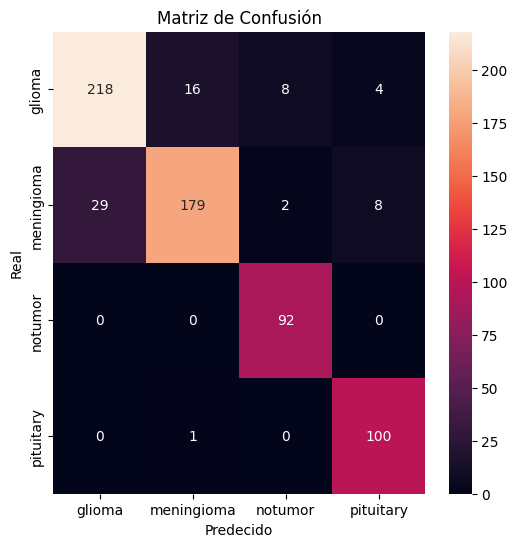

In [72]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel("Predecido")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# f1-score, precision, recall

In [ ]:
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.88      0.89      0.88       246
  meningioma       0.91      0.82      0.86       218
     notumor       0.90      1.00      0.95        92
   pituitary       0.89      0.99      0.94       101

    accuracy                           0.90       657
   macro avg       0.90      0.92      0.91       657
weighted avg       0.90      0.90      0.90       657



# Prueba de confianza

In [73]:
# Número de batches disponibles
num_batches = len(test_data)

# Elegimos un batch aleatorio
batch_index = random.randint(0, num_batches-1)

images, labels = test_data[batch_index]  

# Seleccionar 5 índices del batch
idxs = random.sample(range(len(images)), 10)

selected_images = [images[i] for i in idxs]
selected_labels = [labels[i] for i in idxs]

print("🚀 10 imágenes seleccionadas correctamente desde DirectoryIterator")

🚀 10 imágenes seleccionadas correctamente desde DirectoryIterator


In [74]:
images_array = np.array(selected_images)


preds = model.predict(images_array)


pred_labels = np.argmax(preds, axis=1)
confidences = np.max(preds, axis=1)


class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]  

print("\n🔍 Resultados del modelo:\n")
for i in range(10):
    real_index = int(np.argmax(selected_labels[i]))  
    pred_index = int(pred_labels[i])

    real = class_names[real_index]
    pred = class_names[pred_index]
    conf = confidences[i] * 100

    print(f"Imagen {i+1}")
    print(f"    Real       → {real}")
    print(f"    Predicción → {pred}  ({conf:.2f}% de confianza)")
    print("-" * 45)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

🔍 Resultados del modelo:

Imagen 1
    Real       → meningioma
    Predicción → meningioma  (71.60% de confianza)
---------------------------------------------
Imagen 2
    Real       → meningioma
    Predicción → meningioma  (98.87% de confianza)
---------------------------------------------
Imagen 3
    Real       → meningioma
    Predicción → meningioma  (99.99% de confianza)
---------------------------------------------
Imagen 4
    Real       → meningioma
    Predicción → meningioma  (75.53% de confianza)
---------------------------------------------
Imagen 5
    Real       → meningioma
    Predicción → meningioma  (96.61% de confianza)
---------------------------------------------
Imagen 6
    Real       → meningioma
    Predicción → meningioma  (99.54% de confianza)
---------------------------------------------
Imagen 7
    Real       → meningioma
    Predicción → meningioma  (99.92% de confianza)
-------------------------------------------

# Función para predicción de imagen

In [79]:
CLASS_NAMES = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

def imagenet_preprocess(image: Image.Image):
    image = image.resize(IMG_SIZE)
    x = np.array(image).astype("float32") / 255.0  # Normalización básica a [0,1]

    mean = np.array([0.485, 0.456, 0.406]) # Media de ImageNet
    std  = np.array([0.229, 0.224, 0.225]) # Desviación estándar de ImageNet

    x = (x - mean) / std
    x = np.expand_dims(x, axis=0) 

    return x

def predict(image: Image.Image):
    img_array = imagenet_preprocess(image)
    preds = model.predict(img_array, verbose=0)[0]  # softmax → ya suman 1

    probs_dict = {
        CLASS_NAMES[i]: float(preds[i])
        for i in range(len(CLASS_NAMES))
    }

    # 🔹 Probabilidad binaria principal
    prob_no_tumor = probs_dict["No Tumor"]
    prob_tumor = 1.0 - prob_no_tumor

    # 🔹 Subtipos tumorales
    tumor_breakdown = {
        k: v
        for k, v in probs_dict.items()
        if k != "No Tumor"
    }

    # Clase más probable (original)
    idx = np.argmax(preds)
    predicted_class = CLASS_NAMES[idx]
    confidence = float(preds[idx])

    return {
        "Predicción de clase": predicted_class,
        "Confianza": confidence,
        "Probabilidad_no_tumor": prob_no_tumor,
        "Probabilidad_tumor": prob_tumor,
        "Subtipos tumorales": tumor_breakdown,
        "Todas las probabilidades": probs_dict
    }



In [80]:
img=Image.open("./Epic and CSCR hospital Dataset/Test_final/meningioma/1454.jpg").convert("RGB")
prediction = predict(img)

In [81]:
prediction

{'Predicción de clase': 'Meningioma',
 'Confianza': 0.995553195476532,
 'Probabilidad_no_tumor': 7.487943598505353e-09,
 'Probabilidad_tumor': 0.9999999925120564,
 'Subtipos tumorales': {'Glioma': 6.058797680452699e-06,
  'Meningioma': 0.995553195476532,
  'Pituitary': 0.004440708551555872},
 'Todas las probabilidades': {'Glioma': 6.058797680452699e-06,
  'Meningioma': 0.995553195476532,
  'No Tumor': 7.487943598505353e-09,
  'Pituitary': 0.004440708551555872}}